In [4]:
!pip install statsmodels

In [3]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import statsmodels.api as sm
from shapely import wkt
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

In [4]:
df = pd.read_csv(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\bufferdatasf.csv")
df["geometry"] = df["geometry"].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry="geometry")
gdf = gdf.set_crs("EPSG:4269", inplace=True)



In [6]:
with rasterio.open(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\maskphily-naip.tif") as src:
    naip_crs = src.crs

gdf = gdf.to_crs(naip_crs)

In [7]:
def green_index(band_array):
    red = band_array[0].astype("float32")
    green = band_array[1].astype("float32")
    blue = band_array[2].astype("float32")
    # Simple "Green Leaf Index"
    return (green - red) / (green + red + 1e-5)

In [12]:
with rasterio.open(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\maskphily-naip.tif") as src:
    rgb = src.read([1, 2, 3])  # assuming NAIP is RGB
    profile = src.profile
    profile.update(count=1, dtype='float32')
    green_idx = green_index(rgb)

    with rasterio.open("veg1.tif", "w", **profile) as dst:
        dst.write(green_idx, 1)

MemoryError: Unable to allocate 3.10 GiB for an array with shape (29999, 27709) and data type float32

In [13]:
stats = zonal_stats(gdf, "veg.tif", stats=["mean"], geojson_out=True)
veg_means = [feat["properties"]["mean"] for feat in stats]
gdf["veg_coverage"] = veg_means

C:\Users\kalmanj\AppData\Local\anaconda3\envs\urbanspatial\lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [14]:
veg_grouped = gdf.groupby("geocode")["veg_coverage"].mean()
print("Average vegetation coverage:")
print(veg_grouped)
veg_grouped = veg_grouped.reset_index()

Average vegetation coverage:
geocode
42101000101    0.066459
42101000102    0.065511
42101000200    0.045479
42101000300    0.059816
42101000401    0.059010
                 ...   
42101980905    0.060643
42101980906    0.046935
42101989100    0.086583
42101989200    0.086726
42101989300    0.044199
Name: veg_coverage, Length: 408, dtype: float64


In [15]:
veg_merged = df.merge(veg_grouped[['geocode', 'veg_coverage']], on='geocode', how='left')
veg_means = gdf.groupby("bufferzone")["veg_coverage"].mean()
print(veg_means)
print(gdf.groupby("bufferzone")["veg_coverage"].std())

bufferzone
Inside     0.059758
Outside    0.068712
Name: veg_coverage, dtype: float64
bufferzone
Inside     0.016402
Outside    0.023595
Name: veg_coverage, dtype: float64


In [16]:
print(veg_merged)

         geocode bufferzone  como.rate  \
0    42101039100     Inside   0.000000   
1    42101980902     Inside   0.000000   
2    42101980904    Outside   0.000000   
3    42101980903     Inside   0.000000   
4    42101980906    Outside   0.000000   
..           ...        ...        ...   
403  42101013602    Outside   0.143333   
404  42101034502    Outside   0.279412   
405  42101000902     Inside   0.225490   
406  42101001201     Inside   0.132701   
407  42101002702     Inside   0.198238   

                                              geometry  veg_coverage  
0    MULTIPOLYGON (((-75.22235 39.93105, -75.22129 ...      0.105444  
1    MULTIPOLYGON (((-75.20684 39.93409, -75.20655 ...      0.073512  
2    MULTIPOLYGON (((-75.21243 39.92523, -75.2113 3...      0.044030  
3    MULTIPOLYGON (((-75.20422 39.93285, -75.20305 ...      0.053183  
4    MULTIPOLYGON (((-75.21612 39.90964, -75.21454 ...      0.046935  
..                                                 ...           ... 

In [17]:
bufferzone_stats = veg_merged.groupby('bufferzone')['veg_coverage'].agg(['max', 'min']).reset_index()
bufferzone_stats['max_veg_coverage'] = bufferzone_stats['max']
bufferzone_stats['min_veg_coverage'] = bufferzone_stats['min']
print(bufferzone_stats)


  bufferzone       max       min  max_veg_coverage  min_veg_coverage
0     Inside  0.126742  0.018779          0.126742          0.018779
1    Outside  0.144511  0.019346          0.144511          0.019346


In [18]:
bar_colors={'Inside': '#e4fe88', 'Outside': '#00614e'}

C:\Users\kalmanj\AppData\Local\Temp\ipykernel_8276\3507788968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x='bufferzone', y='veg_coverage', data=veg_merged, palette=bar_colors)


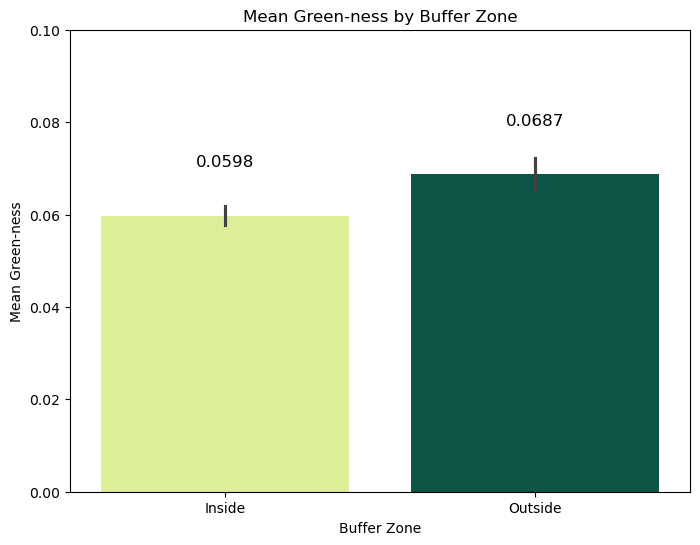

In [25]:
plt.figure(figsize=(8, 6))  # Set figure size
ax=sns.barplot(x='bufferzone', y='veg_coverage', data=veg_merged, palette=bar_colors)

# Add labels and title
plt.xlabel('Buffer Zone')
plt.ylabel('Mean Green-ness')
plt.title('Mean Green-ness by Buffer Zone')
for p in ax.patches:  # Loop through the bars (patches)
    height = p.get_height()  # Get the height (value) of each bar
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01,  # Position the text
            f'{height:.4f}',  # Format the text to 2 decimal places
            ha="center", va="bottom", fontsize=12)  # Adjust the alignment and font size
plt.ylim(0, 0.1)
plt.show()

In [20]:
mu = veg_merged["veg_coverage"].mean()
sigma = veg_merged["veg_coverage"].std()
veg_merged["veg_cat"] = pd.cut(
    veg_merged["veg_coverage"],
    bins=[-np.inf, mu - sigma, mu + sigma, np.inf],
    labels=["Low", "Medium", "High"]
)
min_val = veg_merged['veg_coverage'].min()
max_val = veg_merged['veg_coverage'].max()

# Define thresholds
low_thresh = mu - sigma
high_thresh = mu + sigma

# Build a lookup table
lookup = pd.DataFrame({
    "Category": ["Low", "Medium", "High"],
    "Range": [
        f'[{min_val:.3f}, {low_thresh:.3f})',
        f'[{low_thresh:.3f}, {high_thresh:.3f})',
        f'[{high_thresh:.3f}, {max_val:.3f}]'
    ]
})

print(lookup.to_string(index=False))

Category          Range
     Low [0.019, 0.043)
  Medium [0.043, 0.084)
    High [0.084, 0.145]


In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Read CSV
fhcs = pd.read_csv(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\fqhcsphilly.csv")  # must have e.g. 'lon' & 'lat' columns
geometry = [Point(xy) for xy in zip(fhcs.lon, fhcs.lat)]
fhcs = gpd.GeoDataFrame(fhcs, geometry=geometry)
fhcs = fhcs.set_crs("EPSG:4269", inplace=False)



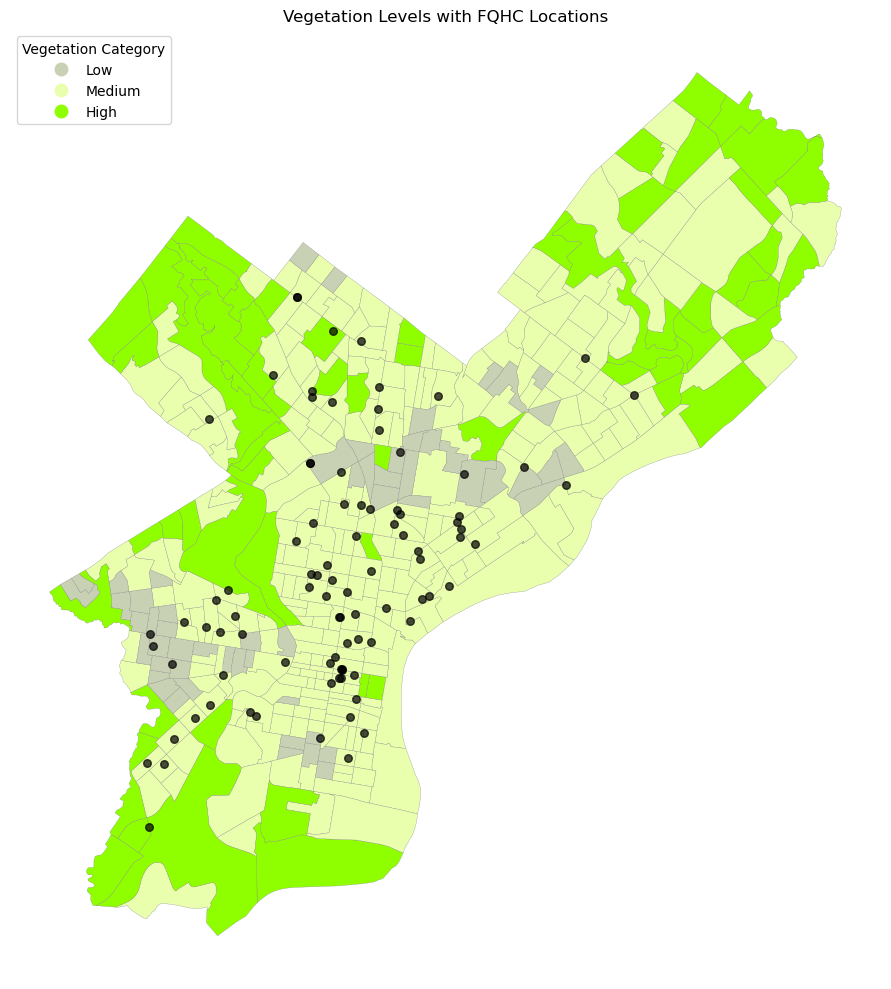

In [31]:
from matplotlib.colors import ListedColormap
if not isinstance(veg_merged, gpd.GeoDataFrame):
    veg_merged = gpd.GeoDataFrame(veg_merged, geometry="geometry")
cmap = ListedColormap(['#c9d1b4', '#eaffae', '#8fff00'])  

fig, ax = plt.subplots(figsize=(10,10))
veg_merged.plot(
    column='veg_cat',
    cmap=cmap,
    legend=True,
    categorical=True,
    legend_kwds={'loc': 'upper left', 'title': 'Vegetation Category'},
    linewidth=0.2,
    edgecolor='gray',
    ax=ax
)
fhcs.plot(
    ax=ax,
    marker='o',
    color='black',
    markersize=30,
    alpha=0.7,
    label='Health Locations'    # change label as appropriate
)

ax.set_title('Vegetation Levels with FQHC Locations')
ax.axis('off')
plt.tight_layout()
plt.show()


In [32]:
pts_with_cat = gpd.sjoin(
    fhcs,
    veg_merged[['veg_cat', 'geometry']],
    how='left',
    predicate='within'
)

# 3. Count points per category
counts = (
    pts_with_cat
    .groupby('veg_cat')
    .size()
    .reindex(['Low','Medium','High'], fill_value=0)
    .rename('point_count')
    .reset_index()
)

print(counts)

  veg_cat  point_count
0     Low            9
1  Medium           81
2    High            2


C:\Users\kalmanj\AppData\Local\Temp\ipykernel_8276\3049006210.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  pts_with_cat = gpd.sjoin(
C:\Users\kalmanj\AppData\Local\Temp\ipykernel_8276\3049006210.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('veg_cat')


In [24]:
# Save
# Make a copy to avoid changing the original
veg_fixed = veg_merged.copy()

# Convert all categorical columns to strings
for col in veg_fixed.select_dtypes(include='category').columns:
    veg_fixed[col] = veg_fixed[col].astype(str)

# Now save safely
veg_fixed.to_file("veg_data.gpkg", layer="veg", driver="GPKG")




